# Principal Components Analysis (PCA)

## What we will accomplish

In this notebook we will:
- Learn the concept behind PCA,
- Review the mathematics underlying PCA,
- Show how to implement PCA in `sklearn`,
- Demonstrate the explained variance and the explained variance curve:
    - Introduce the labeled faces in the wild data set and
- See how we can attempt to interpret the results of PCA.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a dark background
set_style("whitegrid")

## The intuition behind PCA

PCA looks to reduce the dimension of a feature set by projecting it onto a lower dimensional space that captures as much of the original variance as possible.

Here is a heuristic algorithm:
1. Center your data so that each feature has 0 mean, this is done for convenience.
2. Find the direction in space along which projections have the highest variance, this produces the first principal component.
3. Find the direction orthogonal to the first principal component that maximizes variance, this is the second principal component.
4. Continue in this way, the kth principal component is the variance-maximizing direction orthogonal to the previous k-1 components.

Let's see what we mean in a 2-D example, we will use `sklearn`'s `PCA` object, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html</a>:

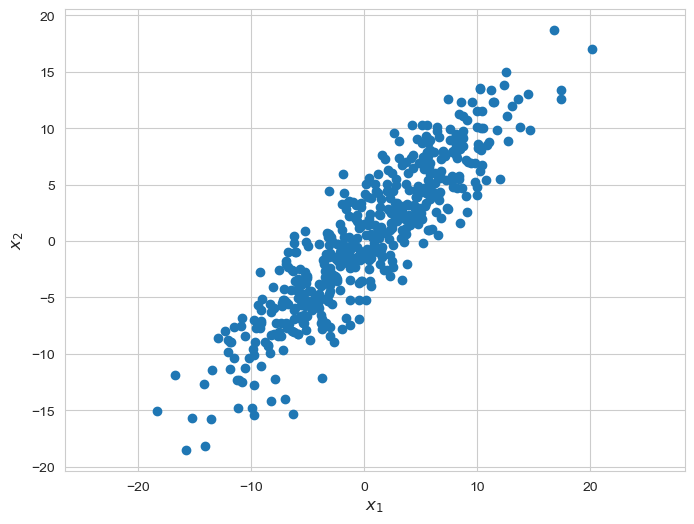

In [2]:
# Make some random data
np.random.seed(440)

x1 = 9*np.random.randn(500)
x2 = 2*np.random.randn(500)

X = np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)], axis = 1)

angle = -np.pi/4

X = X.dot(np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]))


plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1])

plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.axis('equal')

plt.show()

In [3]:
## PCA is stored in decomposition
from sklearn.decomposition import PCA

In [4]:
## make the PCA object
## we'll project down to 2-D
pca = PCA(2)

## Fit the data
pca.fit(X)

PCA(n_components=2)

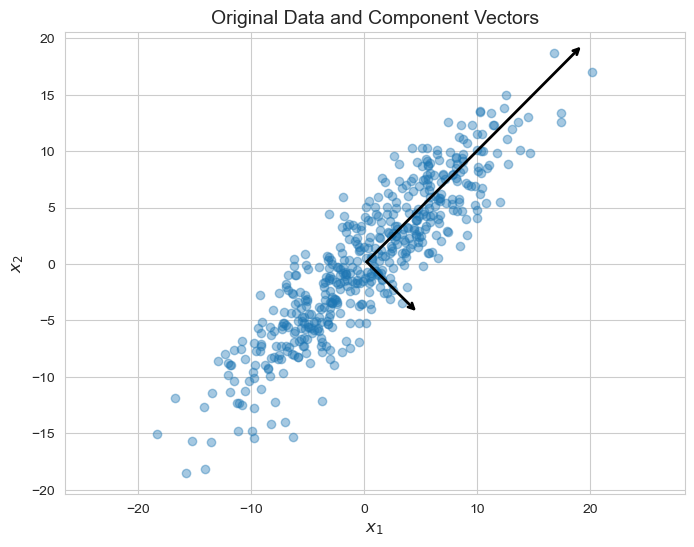

In [5]:
## This function will draw a vector in 2D
## given its components
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, 
                    shrinkB=0,
                    color="black")
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], alpha=.4)

for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
    
    
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.title("Original Data and Component Vectors", fontsize=14)

plt.axis('equal')
plt.show()

The vectors drawn above are called the <i>component vectors</i> of the PCA. When we want to get the transformed version of the data, we get the scalar projection of each observation onto the component vectors. We'll visualize this more explicitly after reviewing the math behind PCA.

In [6]:
# transform gets you the PCA transformed values
fit = pca.transform(X)

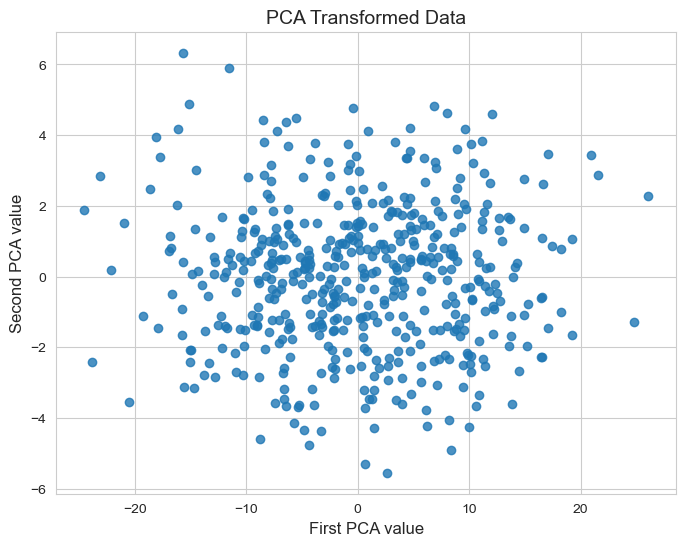

In [7]:
plt.figure(figsize=(8,6))

plt.scatter(fit[:,0], fit[:,1], alpha=.8)

plt.xlabel("First PCA value", fontsize=12)
plt.ylabel("Second PCA value", fontsize=12)

plt.title("PCA Transformed Data", fontsize=14)

plt.show()

## The math behind PCA

We consider the maximal variance formulation of the problem, for those interested in equivalent formulations check the associated `Practice Problems` notebook.

Suppose we have $n$ observations of $m$ features, let $X_1, X_2, \dots, X_m$ be $n$ by $1$ vectors containing the observations of each of the $m$ features. And for ease of notation assume each has been centered to have mean $0$.

We restrict ourselves to the case of finding the first principal component, the others can be found in a similar fashion.

Let 
$$
X = \left(X_1 | X_2 | \dots |X_m \right)
$$
be an $n$ by $m$ feature matrix.

Our goal is to find $w=(w_1,w_2,\dots,w_m)^T$ with $||w|| = 1$, such that $\text{Var}(w_1 X_1 + w_2 X_2 + \dots + w_m X_m) = \text{Var}( X w)$ is maximized (note that because $||w||=1$, $Xw$ is a vector of scalar projections of the rows of $X$ onto $w$).

Because we have centered the columns of $X$ we have:

$$
\text{Var}(Xw) = E(w^T X^T X w) = w^T E(X^T X) w = w^T \Sigma w,
$$

where $\Sigma$ is the covariance matrix of $X$.

Our constrained optimization problem is now:

$$
\text{optimize } f(w) = w^T \Sigma w, \text{ constrained to } g(w) = w^T w - 1 = 0.
$$

Using the method of Lagrange multipliers and some matrix calculus (see the references below for a helpful matrix calculus resource):
$$
\partial_w \left(w^T \Sigma w - \lambda (w^T w - 1)\right) = 2 \Sigma w - 2\lambda w.
$$

Setting this equal to $0$ and solving gives
$$
\Sigma w = \lambda w,
$$
the standard eigenvalue setup.

So the vector $w$ that maximizes variance is an eigenvector corresponding to the largest eigenvalue of the covariance matrix of $X$.

This vector is known as the first principal component. 


Note because $\Sigma$ is an $m\times m$ real positive symmetric matrix it has a set of $m$ eigenvalues (assuming $n > m$) with orthogonal eigenvectors. Thus the remaining principal component vectors are the eigenvectors corresponding to the eigenvalues of $\Sigma$ in decreasing order.

##### Scaling data

We typically need to scale our data prior to fitting the PCA model. This is because the variance of a large scale feature is inherently larger than the variance of a small scale feature. So if we have data with vastly differing scales, we will not be recovering the "hidden structure" of the data, but rather showing what columns have the largest scale. A common scaling approach is to run the data through `StandardScaler` first.

Note that we did not do this here, because our data were constructed to have roughly the same scale.

##### In `sklearn`

In `sklearn`'s `PCA` these $w$ vectors are stored in `PCA().components_`.

We will now use `components_` to more explicitly describe what is going on with PCA.

In [8]:
## demonstrate .components here
pca.components_


## define w1 and w2
w1 = pca.components_[0]
w2 = pca.components_[1]

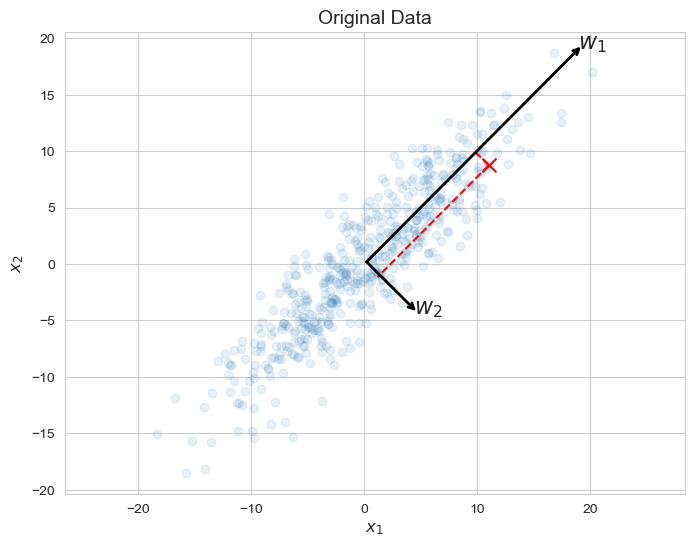

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], alpha=.1)

plt.scatter(X[13, 0], X[13, 1], marker='x', color='r', s=100)

# The scalar projection is (X* dot w1 times w1, X* dot w1 times w1)
plt.plot([X[13,0], X[13,:].dot(w1)*w1[0]], [X[13,1], X[13,:].dot(w1)*w1[1]],'r--')
plt.plot([X[13,0], X[13,:].dot(w2)*w2[0]], [X[13,1], X[13,:].dot(w2)*w2[1]],'r--')

for length, vector, name in zip(pca.explained_variance_, pca.components_, ["$w_1$","$w_2$"]):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
    plt.text(v[0],v[1],name, fontsize=16)
    
    
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)

plt.title("Original Data", fontsize=14)


plt.axis('equal')
plt.show()

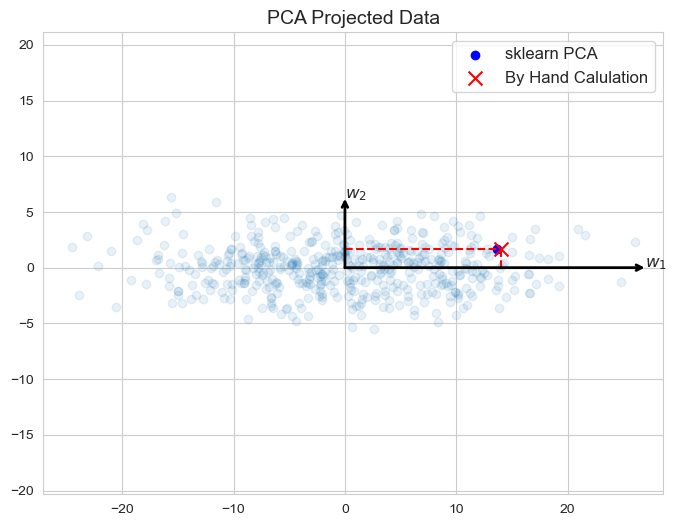

In [10]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

plt.scatter(fit[:, 0], fit[:, 1], alpha=.1)
plt.scatter(fit[13, 0], fit[13, 1], alpha=1, c='b', label="sklearn PCA")

## calculating the PCA projection by hand
plt.scatter(X[13,:].dot(w1), X[13,:].dot(w2), c='r', marker='x', s=100, label="By Hand Calulation")

arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, 
                    shrinkB=0,
                    color="black")
ax.annotate('', [3 * np.sqrt(pca.explained_variance_[0]),0], [0,0], arrowprops=arrowprops)
plt.text(3 * np.sqrt(pca.explained_variance_[0]),0,"$w_1$", fontsize=12)
ax.annotate('', [0, 3 * np.sqrt(pca.explained_variance_[1])], [0,0], arrowprops=arrowprops)
plt.text(0,3 * np.sqrt(pca.explained_variance_[1]),"$w_2$", fontsize=12)
plt.plot([X[13,:].dot(w1),X[13,:].dot(w1)], [0, X[13,:].dot(w2)],'r--')
plt.plot([0,X[13,:].dot(w1)], [X[13,:].dot(w2), X[13,:].dot(w2)],'r--')

plt.legend(fontsize=12)

plt.title("PCA Projected Data", fontsize=14)
plt.axis("equal")

plt.show()

## Explained variance

For each weight vector, $w$, we call $\text{Var}( X w)$ the explained variance due to the principal component $w$. We can think of this as the variance of $X$ explained by the prinicpal component $w$. In `sklearn` we can access this with `explained_variance_`.

In [11]:
## demonstrate explained_variance_
pca.explained_variance_

array([80.45582452,  4.25494023])

At times it can be useful to think of this in terms of the portion of $\text{Var}(X)$ explained by the principal direction, $w$. As we will demonstrate below, this can be helpful in determining how many components we should project down to. 

We can access this with `explained_variance_ratio_`.

In [12]:
## demonstrate explained_variance_ratio_
pca.explained_variance_ratio_

array([0.94977096, 0.05022904])

### Example: Labeled faces in the wild

To help illustrate the utility of the explained variance we will use a new data set, the labeled faces in the wild data set, <a href="http://vis-www.cs.umass.edu/lfw/">http://vis-www.cs.umass.edu/lfw/</a>. Let's demonstrate this data before moving forward.

In [13]:
## This will help us get the data
from sklearn.datasets import fetch_lfw_people

In [14]:
## Load the data
people = fetch_lfw_people(min_faces_per_person=20, resize=.7)

## we'll discuss this soon
image_shape = people.images[0].shape

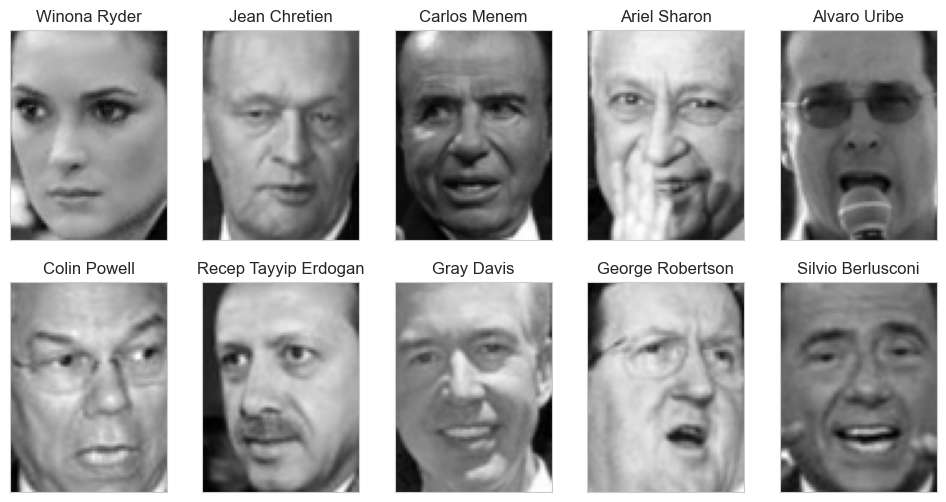

In [15]:
fig,ax = plt.subplots(2, 5, figsize=(12,6),
                         subplot_kw = {'xticks':(), 'yticks':()})

for target, image, ax in zip(people.target, people.images, ax.ravel()):
    ax.imshow(image, cmap='gray')
    ax.set_title(people.target_names[target])

Each observation in this data set represents a publicly sourced 87 by 65 grayscale image of a well known figure (at least well known when the data set was created). This translates to $87\times 65 = 5{,}655$ features for each observation. 

### Choosing the number of  PCA components

This number of features could be computationally expensive for some of the supervised learning algorithms we have learned up to this point, for example $k$-nearest neighbors. It could be useful to run PCA to reduce the number of dimensions, but how many components should we use?

The answer is dependent upon your use case. For example if you are interested in using PCA to produce a visualization of the data, you likely want $2$ or $3$ components. On the other hand if you simply want to use PCA to battle colinearity for a regression model (See the PCA `Practice Problems` notebook) you will want to use as many components as columns.

When the answer is not obvious from your use case, you can turn to the explained variance ratio. 

In [16]:
## scaling the data
X = people['data']

## this scales it so that that the max value
## in a pixel is 1
X = X/255

In [17]:
## make the model
## leaving it blank will have it produce the maximum number
## of possible components
pca = PCA()

pca.fit(X)

pca.components_.shape

(3023, 5655)

### The explained variance curve

We previously mentioned the explained variance ratio as giving the portion of the original variance of $X$ explained by each principal component direction. We often look at the <i>explained variance curve</i> which plots the cumulative explained variance ratio against the number of directions you have considered. Let's do this for the PCA we just fit.

In [18]:
pca.explained_variance_ratio_

array([2.3973641e-01, 1.1280719e-01, 6.7027874e-02, ..., 2.5650190e-08,
       2.4206724e-08, 2.6773540e-12], dtype=float32)

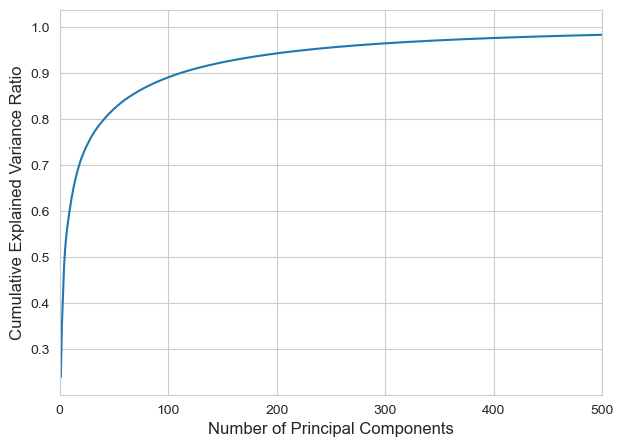

In [19]:
## make the explained variance curve
plt.figure(figsize=(7,5))


plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
            np.cumsum(pca.explained_variance_ratio_))

plt.ylabel("Cumulative Explained Variance Ratio", fontsize=12)
plt.xlabel("Number of Principal Components", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlim(0,500)

plt.show()

What we typically do is look for the <i>elbow</i> in the explained variance curve. The elbow is where the amount of added variance ratio starts to rapidly decrease. We think of this as an indication that addition of another principal direst would start to provide diminishing returns.

In this example it appears that the elbow appears around $100$ components.

#### Alternative: setting a ratio

Alternatively, we could simply set a cumulative ratio that we are happy with. This can be done quite simply with `sklearn`'s `PCA`.

In [20]:
pca = PCA(n_components=.95)

pca.fit(X)

pca.explained_variance_ratio_.shape

(225,)

#### Compressing the data

We can think of PCA as a way to compress the data contained in $X$. 

A neat way to see how well the compressed data compares to the original data takes advantage of some linear algebra.

Suppose that we are in $\mathbb{R}^2$, and that vector $v$ and vector $u$ are perpendicular, then for any vector $x$,

$$
x = \text{proj}_u (x) + \text{proj}_v(x).
$$

Suppose that we have an observation $X^*$, then for any principal component vector $w_l$ we have that:

$$
\text{proj}_{w_l} (X^*) = (X^* \bullet w_l) w_l \equiv \tilde{X}^*_l w_l.
$$

If, as noted above, we define $\tilde{X}^*_l$ to be the $l^{th}$ principal value for observation $*$. Then we can approximate the original $X^*$ with:

$$
X^* \approx \tilde{X}^*_1 w_1 + \tilde{X}^*_2 w_2 + \dots + \tilde{X}^*_L w_L,
$$

where $L$ is the total number of principal components.

For these images we can actually look at these approximations and judge how "good" they are.

In [21]:
## fit a PCA with 3000 comps
pca = PCA(n_components=3000)
pca.fit(X)

## Gives the projection onto the lower dimensional PCA space
X_tilde = pca.transform(X)

In [22]:
## This will give you the reconstruction
## Xtilde dot ws
X_tilde[0,:].dot(pca.components_).reshape(image_shape)

array([[-3.6577749e-04, -3.7126703e-04, -1.6737904e-04, ...,
        -7.0320762e-04, -7.3352270e-04, -7.5983518e-04],
       [-4.6266746e-04, -4.1364040e-04,  4.1608000e-05, ...,
        -5.9789338e-04, -7.5262721e-04, -8.3517446e-04],
       [-5.9864431e-04, -3.5835974e-04,  3.8648662e-04, ...,
        -5.3159439e-04, -6.2274834e-04, -6.7981449e-04],
       ...,
       [-3.9047716e-04, -4.0532817e-04, -4.5300979e-04, ...,
        -1.3557533e-03, -1.3236881e-03, -1.2819847e-03],
       [-3.4929975e-04, -3.4714158e-04, -3.4783635e-04, ...,
        -1.3998603e-03, -1.3502730e-03, -1.2122927e-03],
       [-2.9052136e-04, -2.7549575e-04, -3.4109270e-04, ...,
        -1.4155908e-03, -1.3581311e-03, -1.2006644e-03]], dtype=float32)

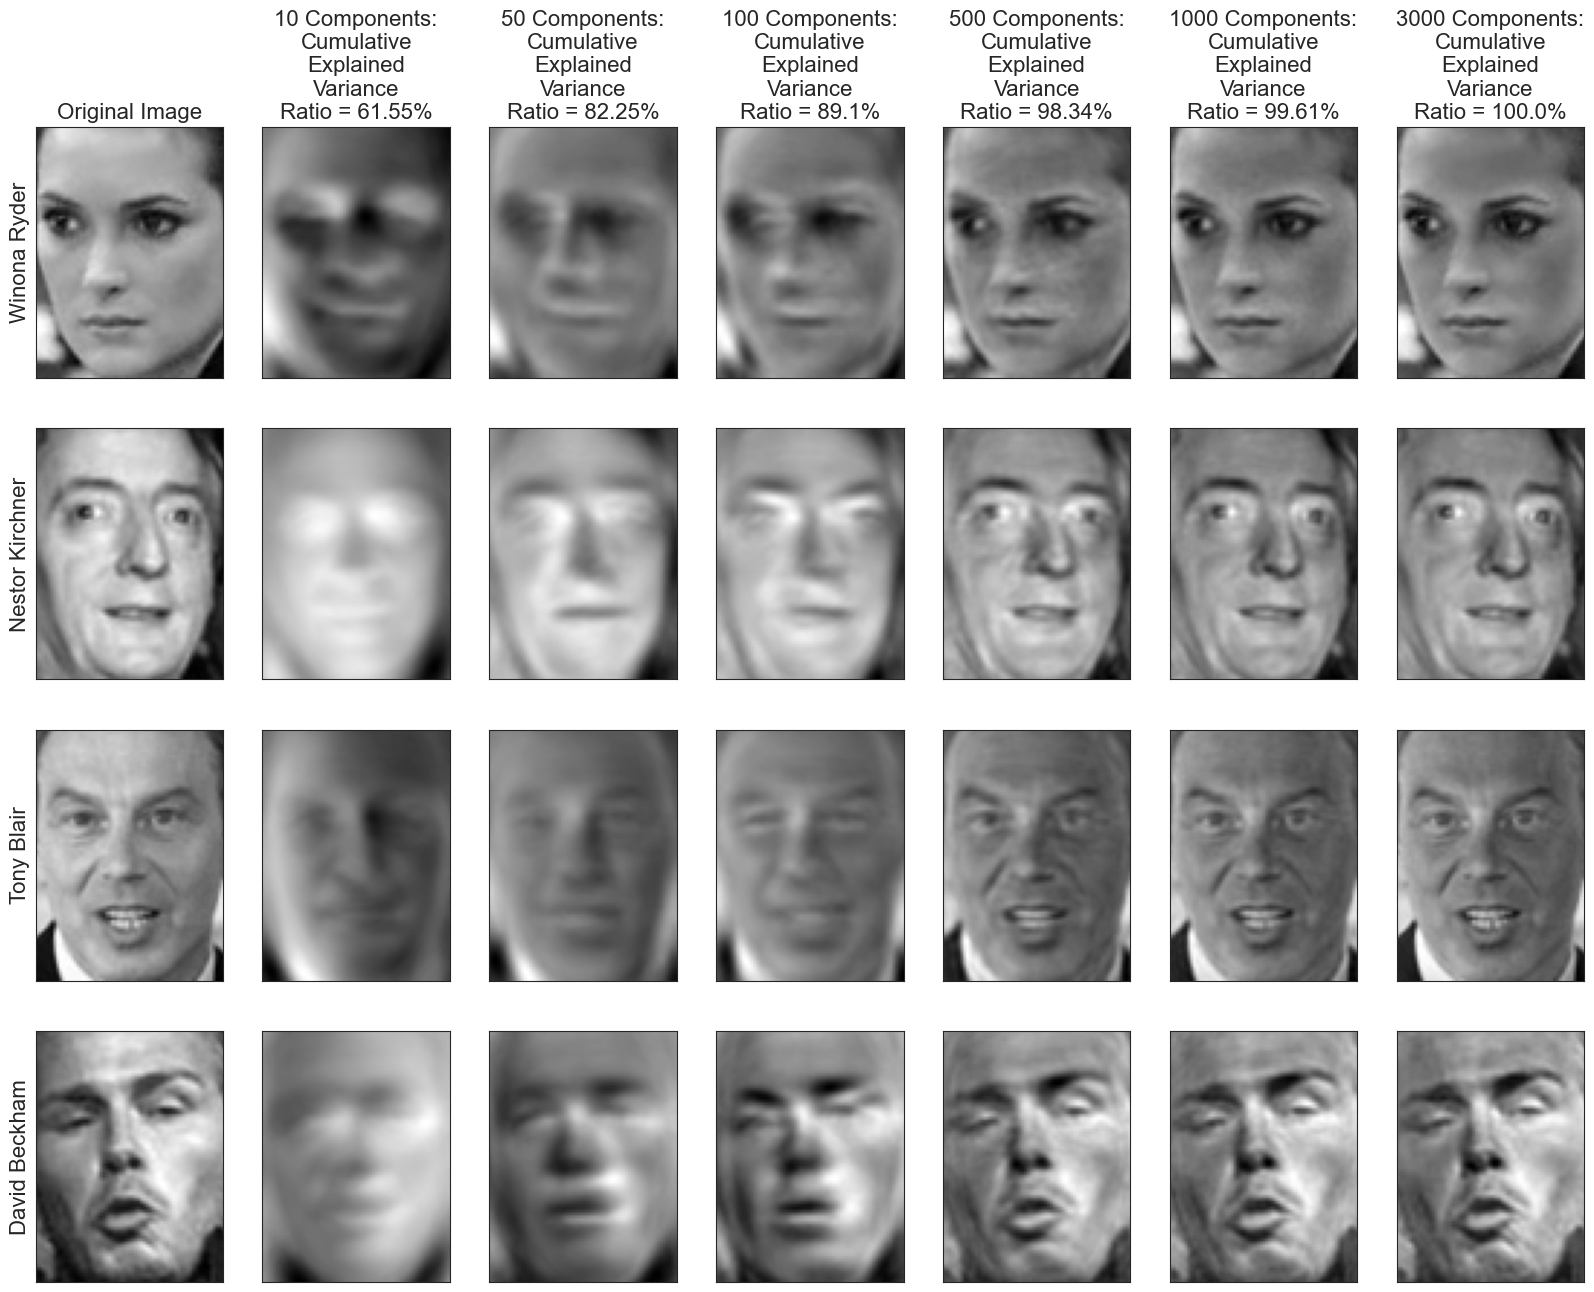

In [23]:
set_style("white")

plt.show()

img_selection = [0,71,201,101]

fig, ax = plt.subplots(4, 7, figsize=(20,15),
                         subplot_kw = {'xticks':(), 'yticks':()})

for j in range(4):
    ax[j,0].imshow(X[img_selection[j]].reshape(image_shape), 
                      cmap='gray')
    ax[j,0].set_ylabel(people.target_names[people.target[img_selection[j]]], fontsize=16)

ax[0,0].set_title("Original Image", fontsize=16)

i = 1
for n_components in [10, 50, 100, 500, 1000, 3000]:
    for j in range(4):
        ax[j,i].imshow(X_tilde[img_selection[j],:n_components].dot(pca.components_[:n_components,:]).reshape(image_shape), 
                      cmap='gray')
    ax[0,i].set_title(str(n_components)+" Components:\n" +
                      "Cumulative\nExplained\nVariance\nRatio = " +
                         str(np.round(100*np.sum(pca.explained_variance_ratio_[:n_components]), 2)) + "%", 
                      fontsize=16)

    i = i + 1

So it looks like that extra bit of explained variance makes the difference between human face and horrible ghost monster!

## Interpreting PCA

While using PCA can be incredibly useful, you will lose some of the interpretability of the original data set's features. For example, principle component 1 is a little more difficult to understand than what the original features were.

Luckily, we can use the component vectors, the $w$s, to help us understand what each principal component direction is <i>capturing</i>.

### Example: Basketball shot distributions

To help explain how to do this we will use another new data set that tracks the shot distribution for NBA teams in the 2000-01 and the 2018-19 seasons. A basketball court can be broken into 15 unique zones like so:

<img src="lecture-5-assets/CourtZones.png" width="40%;"></img>

The data set `nba_team_shots.csv` measures what fraction of every team's shots were taken in each of the 15 zones. Let's load the data now.

In [25]:
shots = pd.read_csv("../../data/nba_team_shots.csv")

In [ ]:
shots.head()

Let's imagine a setting in which someone wanted to see if they could understand the underlying structure in this data using PCA. That is let's apply PCA to the data set.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
## Make the object
scaler = StandardScaler()
pca = PCA(n_components=2)


## Fit the pca
X_scaled = scaler.fit_transform(shots[shots.columns[3:]])
pca.fit(X_scaled)


## get the PCA project
fit = pca.transform(X_scaled)

In [ ]:
set_style("whitegrid")

plt.figure(figsize=(10,5))

plt.scatter(fit[:,0], fit[:,1])

plt.xlabel("First PCA Direction", fontsize=12)
plt.ylabel("Second PCA Direction", fontsize=12)

plt.show()

This is nice, but what does it mean? We can use the component vectors to find out.

Remember our goal is to find $w=(w_1,w_2,\dots,w_m)^T$ with $||w|| = 1$, is such that $\text{Var}(w_1 X_1 + w_2 X_2 + \dots + w_m X_m) = \text{Var}( X w)$. $w$ is our component vector, and we can note that it is the same dimension as each observation $X^{(i)}$. We can associate every entry of the component vector, $w_l$, with it the corresponding column of $X$. The larger the value of $w_l$, the more important the $l^{\text{th}}$ colummn is to that principal direction.

Let's look at our principal component vectors then.

In [ ]:
component_vectors = pd.DataFrame(pca.components_.transpose(),
                                    columns = ['component_1', 'component_2'],
                                    index = shots.columns[3:])

In [ ]:
component_vectors.sort_values('component_1')

It is sometimes more informative to visualize this with a heatmap. Credit to Erd&#337;s Institute Member <a href="https://www.linkedin.com/in/patrick-vallely/">Patrick Vallely</a> for the below images.

<img src="lecture-5-assets/ZonePCAHeat.png" width="75%"></img>

What do these two vectors mean? For any principal component vector, positive (meaning greater than 0) vector entries correspond to more positive principal component values. For example a team with 100% of their shots from Zone 12 will have as positive a first principal component value as possible because that is the most negative row of the first principal component vector table. On the other hand, a team that shot 100% of their shots from Zone 5 will have as positive a first principal component value as possible because that is the most positive row of the first principal component vector table. 

In this way we can read through the principal components and see which features are being picked up in that component. We can also see how this gets reflected in the PCA plot.


##### Blog plug

If this problem interested you, check out my blog post using this data :)

<a href="http://matthew-osborne.com/mtodata/Posts/PCA-in-NBA.html">http://matthew-osborne.com/mtodata/Posts/PCA-in-NBA.html</a>.

## References 

<a href = "https://www.tandfonline.com/doi/abs/10.1080/14786440109462720">On lines and planes of closest fit to systems of points in space</a>

<a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">Univeristy of Waterloo Matrix Cookbook</a>

<a href="http://www.math.kent.edu/~reichel/courses/monte.carlo/alt4.7d.pdf">Kent State University Notes on Random Vectors and Matrices</a>

<a href="http://www.stat.columbia.edu/~fwood/Teaching/w4315/Fall2009/pca.pdf">Columbia PCA notes</a>

<a href="https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf">Central Michigan PCA notes</a>

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)